## TB1 : Introduction au traitement d'image
Karim Bekhti

This projects consists in an example of utilisation of a deep learning architecture (Unet) in order to realize picture's segmentation. The different codes below produce detailed results of the use of such an algorithm, on a relatively small training sample. The results are detailed below and in the PDF document given with this work.

Ce projet consiste en un exemple d'utilisation de deep learning (UNet) pour la segmentation d'images. 
Les différents codes permettant d'obtenir les résultats détaillés dans ci-dessous et dans le PDF sont donnés ci-dessous et commentés. 

Imports :

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import re


c:\Users\kbekh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\kbekh\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Important Variables one could want to change before to run the code. 

In [3]:
epochs = 2 #Proof of concept
batch_size = 8 #smol cpu
test_size = 0.3 #no validation dataset
path = r"C:\Users\kbekh\Desktop\EMSE\Cours\.Projets\Projet Introduction Traitement d'image 2"  #Path to adapt

To simplify the code, some functions are coded in the file UNET

In [4]:
os.chdir(path) #We set the working directory to path
import UNet as un #File given along this file

Here we will define our X_data where we store our input information (our images)
In Y we store our needed output, hence the segmented image

Then we define Y_label and X_train, X_test from X_data and Y_train, Y_test to fill with the neural network previsions.
We let the possibility to reduce the size of the data_base for more flexibility.

In [30]:
X_data, Y_data = un.image_loading(path + r"/image", path + r"/label", False, False) 

In [31]:
#Normalization 
X_data = np.array([cv2.resize(image.astype(np.uint8), (64,64)) for image in X_data])
Y_data = np.array([cv2.resize(image.astype(np.uint8), (64,64)) for image in Y_data])

In [34]:
#We split the samples between test and train samples to feed to the model.
(X_train, X_test, Y_train, Y_test) = train_test_split(X_data, Y_data, test_size=test_size)

We train the model on X_train. We use a Unet model, the adam optimizer and our loss function is a binary crossentropy function.


In [36]:
model = un.unet(input_shape=(64,64, 1), num_classes=1) #Unet function defined in the UNet file given
model.compile(optimizer="adam", loss="binary_crossentropy") #We define the optimizer and loss function 
#Those are usual function and were not tested via cross validation or approaching techniques
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.fit(np.array(X_train), np.array(Y_train), epochs=epochs, batch_size=batch_size) #we fit the model to the data 

Epoch 1/2
18/18 [==============================] - 37s 2s/step - loss: 0.4208
Epoch 2/2
18/18 [==============================] - 33s 2s/step - loss: 0.1610


Then, in order to test our model, we predict the results of the X_test function.

In [37]:
X_test=np.array(X_test)
Y_test=np.array(Y_test)
#And now we predict with the tests arrays 
Neural_predict = model.predict(X_test)

2/2 [==============================] - 6s 2s/step


The prediction gives back probabilities to be in each class : here we simply compare to the mean but we could use functions like argmax to transform those.

In [38]:
predicted_labels = (Neural_predict > np.mean(Neural_predict)).astype(int) 
#we transform the resulting probability in a label

Visualisation of the images (in order to compare quickly)

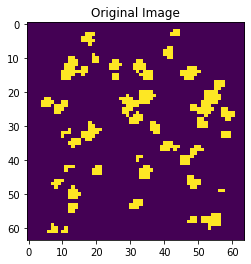

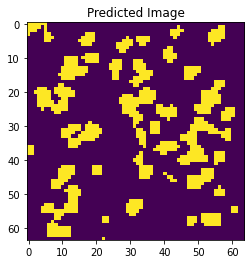

In [39]:
n=3
plt.imshow(Y_test[n])
plt.title("Original Image")
plt.show()
plt.imshow((predicted_labels[n]*255))
plt.title("Predicted Image")
plt.show()

Different metrics for precision.

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    219353
           1       0.52      0.95      0.67     26407

    accuracy                           0.90    245760
   macro avg       0.76      0.92      0.81    245760
weighted avg       0.94      0.90      0.91    245760



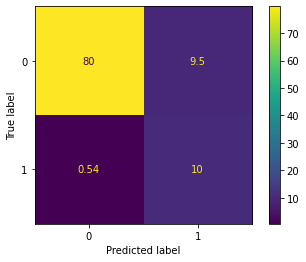

In [ ]:
def precision(Real_image, Prediction_image): #for images
    from sklearn.metrics import confusion_matrix, classification_report
    Real = Real_image.flatten()
    Prediction = Prediction_image.flatten()
    confm = confusion_matrix(Real, Prediction)
    report = classification_report(Real, Prediction, zero_division=1)
    
    disp = ConfusionMatrixDisplay(confm*100/np.sum(confm))
    disp.plot()
    print(report)
    return report 
# This function precision gives back a few metrics for our predictions (we use the flattened version of our 
# predicted images)

#This part allows to retrieve the accuracy in order to use it to name our resulting folder.
accuracy="unknown"
report = precision(Y_test, predicted_labels)
accuracy_pattern = r"accuracy\s+([\d.]+)"
accuracy_match = re.search(accuracy_pattern, report)
if accuracy_match:
    accuracy = float(accuracy_match.group(1))
else:
    print("Accuracy not found in the string.")